In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Dataset/preprocessed_data.xlsx")

In [ ]:

df.head()


,System Code,Latitude,Longitude,Road Description,Road Condition,Lighting Conditions,Weather Condition,Rush Hour,Alcohol Suspected,Speed Limit Category,Severity
0,State Highway,39.525490,-107.322530,Intersection Related,Snowy,Daylight,Snow,0,No,Low,slight
1,County Road,39.752829,-104.939516,Non-Intersection,Icy,Dark – Unlighted,Clear,0,No,Low,slight
2,City Street,39.828850,-105.044020,Non-Intersection,Dry,Dark – Unlighted,Clear,0,No,Low,slight
3,City Street,39.704610,-105.013560,Non-Intersection,Dry,Dark – Unlighted,Clear,0,No,Low,slight
4,County Road,39.752829,-104.939516,Intersection Related,Dry,Dark – Unlighted,Clear,0,No,Low,slight


In [ ]:
df.dtypes

,0
System Code,object
Latitude,float64
Longitude,float64
Road Description,object
Road Condition,object
Lighting Conditions,object
Weather Condition,object
Rush Hour,int64
Alcohol Suspected,object
Speed Limit Category,object


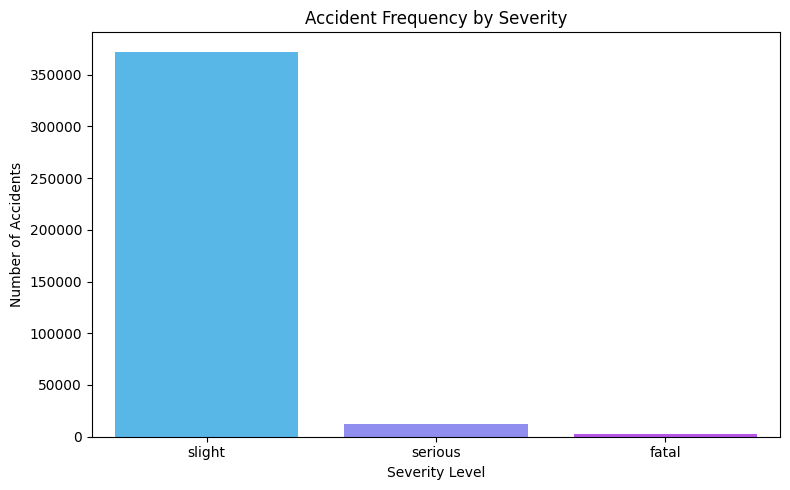

In [ ]:
severity_counts = df["Severity"].value_counts()

severity_df = severity_counts.reset_index()
severity_df.columns = ["Severity", "Number of Accidents"]


plt.figure(figsize=(8, 5))
sns.barplot(x="Severity", y="Number of Accidents", hue="Severity", palette="cool", data=severity_df, legend=False)

# Titles and labels
plt.title("Accident Frequency by Severity")
plt.xlabel("Severity Level")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=0)  # No rotation needed for small categories
plt.tight_layout()
plt.show()


In [ ]:
df["Alcohol Suspected"] = df["Alcohol Suspected"].map({'Yes': 1, 'No': 0, 'Unknown': 0}).astype('Int64')

In [ ]:
categorical_columns = [
    'System Code', 'Road Description', 'Road Condition',
    'Lighting Conditions', 'Weather Condition', 'Speed Limit Category'
]

In [ ]:
df_encoded = pd.get_dummies(df, columns=categorical_columns)


In [ ]:
numerical_columns = ['Rush Hour', 'Alcohol Suspected']
df_encoded[numerical_columns] = df_encoded[numerical_columns].astype('float64')

for col in df_encoded.columns:
    if col not in ['Severity']:  # Exclude the target column
        df_encoded[col] = df_encoded[col].astype('float64')

In [ ]:
X = df_encoded.drop(columns=['Severity'])
y = df_encoded['Severity']

In [ ]:
X.columns

Index(['Latitude', 'Longitude', 'Rush Hour', 'Alcohol Suspected', 'System Code_City Street',
       'System Code_County Road', 'System Code_Frontage Road', 'System Code_Interstate Highway',
       'System Code_State Highway', 'Road Description_Alley Related',
       'Road Description_At Intersection', 'Road Description_Auxiliary Lane',
       'Road Description_Crossover-Related ', 'Road Description_Driveway Access Related',
       'Road Description_Express/Managed/HOV Lane', 'Road Description_Intersection Related',
       'Road Description_Mid-Block Crosswalk', 'Road Description_Non-Intersection',
       'Road Description_Parking Lot', 'Road Description_Railroad Crossing Related',
       'Road Description_Ramp', 'Road Description_Ramp-related', 'Road Description_Roundabout',
       'Road Description_Shared-Use Path or Trail', 'Road Condition_Dry',
       'Road Condition_Dry W/Visible Icy Road Treatment', 'Road Condition_Foreign Material',
       'Road Condition_Icy', 'Road Condition_Ic

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
X_smote = pd.DataFrame(X_smote, columns=X.columns)
y_smote = pd.Series(y_smote, name='Severity')
y_smote.value_counts()

,count
Severity,
slight,372255
serious,372255
fatal,372255


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_smote)
print("Target variable encoded. Classes:", label_encoder.classes_)

Target variable encoded. Classes: ['fatal' 'serious' 'slight']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y, test_size=0.2, random_state=42, stratify=y_smote)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30]},
             scoring='f1_weighted')

In [ ]:
dt_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1-score:", grid_search.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best cross-validation F1-score: 0.7543075034326476


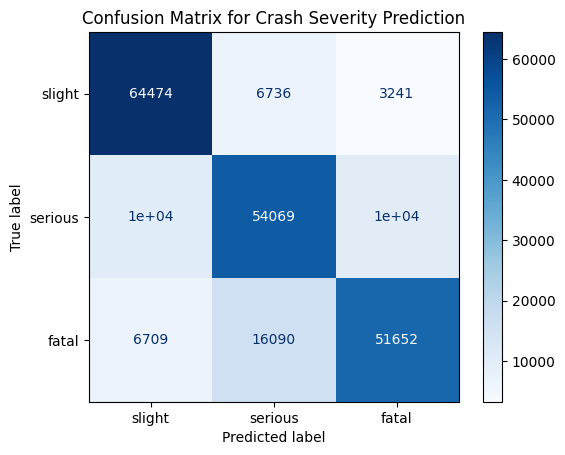

Confusion Matrix:
[[64474  6736  3241]
 [10227 54069 10155]
 [ 6709 16090 51652]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = dt_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['slight', 'serious', 'fatal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.show()

print("Confusion Matrix:")
print(cm)

In [ ]:
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {dt_accuracy:.4f}\n")

Accuracy: 0.7620



In [ ]:
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['slight', 'serious', 'fatal']))

if hasattr(dt_model, 'predict_proba'):
    y_score = dt_model.predict_proba(X_test)
    y_test_one_hot = pd.get_dummies(y_test)
    roc_auc = roc_auc_score(y_test_one_hot, y_score, multi_class='ovr')
    print("ROC-AUC Score (One-vs-Rest):", roc_auc)
else:
    print("ROC-AUC not computed: predict_proba not available for this model.")

Classification Report on Test Set:
              precision    recall  f1-score   support

      slight       0.79      0.87      0.83     74451
     serious       0.70      0.73      0.71     74451
       fatal       0.79      0.69      0.74     74451

    accuracy                           0.76    223353
   macro avg       0.76      0.76      0.76    223353
weighted avg       0.76      0.76      0.76    223353

ROC-AUC Score (One-vs-Rest): 0.9130794543415242


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy', n_jobs=2, verbose=1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'max_depth': [10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [ ]:
rf_best_model = rf_grid.best_estimator_
print("Best parameters:", rf_grid.best_params_)
print("Best cross-validation F1-score:", rf_grid.best_score_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation F1-score: 0.8903551776783836


In [ ]:
rf_pred = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Accuracy: {rf_accuracy:.4f}\n")

Accuracy: 0.9063



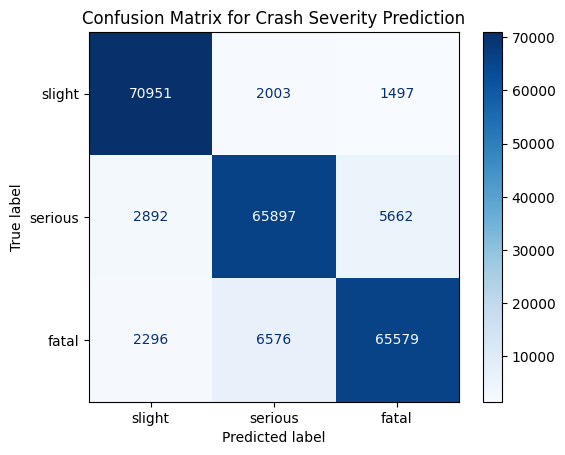

Confusion Matrix:
[[70951  2003  1497]
 [ 2892 65897  5662]
 [ 2296  6576 65579]]


In [ ]:
cm = confusion_matrix(y_test, rf_pred, labels=[0, 1, 2])


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['slight', 'serious', 'fatal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.show()

print("Confusion Matrix:")
print(cm)

In [ ]:
print("Classification Report on Test Set:")
print(classification_report(y_test, rf_pred, target_names=['slight', 'serious', 'fatal']))

if hasattr(rf_best_model, 'predict_proba'):
    y_score = rf_best_model.predict_proba(X_test)
    y_test_one_hot = pd.get_dummies(y_test)
    roc_auc = roc_auc_score(y_test_one_hot, y_score, multi_class='ovr')
    print("ROC-AUC Score (One-vs-Rest):", roc_auc)
else:
    print("ROC-AUC not computed: predict_proba not available for this model.")

Classification Report on Test Set:
              precision    recall  f1-score   support

      slight       0.93      0.95      0.94     74451
     serious       0.88      0.89      0.88     74451
       fatal       0.90      0.88      0.89     74451

    accuracy                           0.91    223353
   macro avg       0.91      0.91      0.91    223353
weighted avg       0.91      0.91      0.91    223353

ROC-AUC Score (One-vs-Rest): 0.9780233491863758


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 6],
    'learning_rate': [0.1],
    'subsample': [1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=2, verbose=1)
xgb_grid.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:29:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 6],
                         'n_estimators': [100], 'subsample': [1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
xgb_best_model = xgb_grid.best_estimator_
xgb_pred = xgb_best_model.predict(X_test)
print("XGBClassifier Performance (Best Parameters: {}):".format(xgb_grid.best_params_))
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))


XGBClassifier Performance (Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}):
              precision    recall  f1-score   support

       fatal       0.64      0.75      0.69     74451
     serious       0.56      0.45      0.50     74451
      slight       0.66      0.67      0.67     74451

    accuracy                           0.62    223353
   macro avg       0.62      0.62      0.62    223353
weighted avg       0.62      0.62      0.62    223353



In [ ]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"Accuracy: {xgb_accuracy:.4f}")


Accuracy: 0.6239


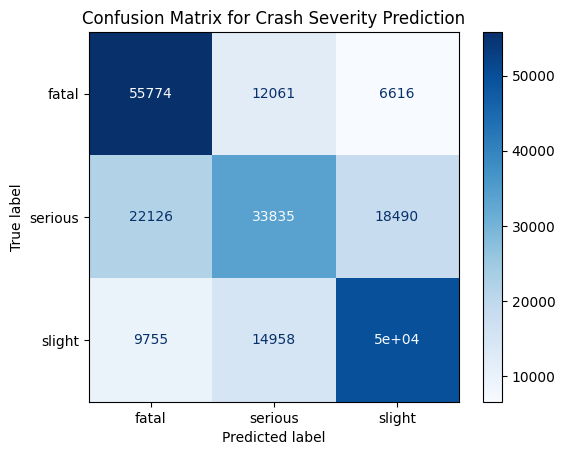

Confusion Matrix:
[[55774 12061  6616]
 [22126 33835 18490]
 [ 9755 14958 49738]]


In [ ]:
cm = confusion_matrix(y_test, xgb_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Crash Severity Prediction')
plt.show()

print("Confusion Matrix:")
print(cm)

In [ ]:
print("Classification Report on Test Set:")
print(classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))

# ROC-AUC (One-vs-Rest)
if hasattr(xgb_best_model, 'predict_proba'):
    y_score = xgb_best_model.predict_proba(X_test)

    # One-hot encode the integer labels for ROC-AUC
    from sklearn.preprocessing import label_binarize
    y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2])  # adjust classes if needed

    roc_auc = roc_auc_score(y_test_one_hot, y_score, multi_class='ovr')
    print(f"ROC-AUC Score (One-vs-Rest): {roc_auc:.4f}")
else:
    print("ROC-AUC not computed: predict_proba not available for this model.")

Classification Report on Test Set:
              precision    recall  f1-score   support

       fatal       0.64      0.75      0.69     74451
     serious       0.56      0.45      0.50     74451
      slight       0.66      0.67      0.67     74451

    accuracy                           0.62    223353
   macro avg       0.62      0.62      0.62    223353
weighted avg       0.62      0.62      0.62    223353

ROC-AUC Score (One-vs-Rest): 0.8106


In [ ]:
model_accuracies = {
    'DecisionTreeClassifier': dt_accuracy,
    'RandomForestClassifier': rf_accuracy,
    'XGBClassifier': xgb_accuracy
}
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]
print("Model Comparison:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")
print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

Model Comparison:
DecisionTreeClassifier: 0.7620
RandomForestClassifier: 0.9063
XGBClassifier: 0.6239

Best Model: RandomForestClassifier with Accuracy: 0.9063


In [ ]:
import pickle
if best_model_name == 'DecisionTreeClassifier':
    best_model = dt_model
    model_filename = 'best_model_decision_tree.pkl'
elif best_model_name == 'RandomForestClassifier':
    best_model = rf_best_model
    model_filename = 'best_model_random_forest.pkl'
else:
    best_model = xgb_best_model
    model_filename = 'best_model_xgboost.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model saved as '{model_filename}'")

Best model saved as 'best_model_random_forest.pkl'
